In [3]:
# Import Dependencies
import pandas as pd

# Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import json

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

# Defining a variable to store the dataset from kaggle to access
source = "alopez247/pokemon"

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt

# Removing warnings
import warnings
# Suppress future and user warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
# Accessing Data from Kaggle

# Load Kaggle API key from [redacted]
with open("secrets/kaggle.json") as f:
    kaggle_credentials = json.load(f)

# Set enviro variables for API
os.environ["KAGGLE_USERNAME"] = kaggle_credentials["username"]
os.environ["KAGGLE_KEY"] = kaggle_credentials["key"]

# Kaggle API:
api = KaggleApi()
api.authenticate()

# Accessing Dataset
path = api.dataset_download_files(source, unzip= True, path= "data")


Dataset URL: https://www.kaggle.com/datasets/alopez247/pokemon


In [5]:
# Creating the dataframe!

df = pd.read_csv("data/pokemon_alopez247.csv", index_col= 0)
print(df.head(6))

              Name Type_1  Type_2  Total  HP  Attack  Defense  Sp_Atk  Sp_Def  \
Number                                                                          
1        Bulbasaur  Grass  Poison    318  45      49       49      65      65   
2          Ivysaur  Grass  Poison    405  60      62       63      80      80   
3         Venusaur  Grass  Poison    525  80      82       83     100     100   
4       Charmander   Fire     NaN    309  39      52       43      60      50   
5       Charmeleon   Fire     NaN    405  58      64       58      80      65   
6        Charizard   Fire  Flying    534  78      84       78     109      85   

        Speed  ...  Color  hasGender Pr_Male  Egg_Group_1  Egg_Group_2  \
Number         ...                                                       
1          45  ...  Green       True   0.875      Monster        Grass   
2          60  ...  Green       True   0.875      Monster        Grass   
3          80  ...  Green       True   0.875      Monst

In [6]:
# Grabbing the columns to know what I need to remove/encode
col_list = df.columns.tolist()

# Removing name for the model
col_list = [item for item in col_list if item not in ["Name"]]
print(col_list)
print(df.info())


['Type_1', 'Type_2', 'Total', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation', 'isLegendary', 'Color', 'hasGender', 'Pr_Male', 'Egg_Group_1', 'Egg_Group_2', 'hasMegaEvolution', 'Height_m', 'Weight_kg', 'Catch_Rate', 'Body_Style']
<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 1 to 721
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              721 non-null    object 
 1   Type_1            721 non-null    object 
 2   Type_2            350 non-null    object 
 3   Total             721 non-null    int64  
 4   HP                721 non-null    int64  
 5   Attack            721 non-null    int64  
 6   Defense           721 non-null    int64  
 7   Sp_Atk            721 non-null    int64  
 8   Sp_Def            721 non-null    int64  
 9   Speed             721 non-null    int64  
 10  Generation        721 non-null    int64  
 11  isLegendary       721 non-null   

In [7]:
# Prepping the data for clustering

# Creating Cluster DF
df_cluster = df[col_list]

# Encoding categorical data

# Encoding pokemon types
# NANs
df_cluster["Type_2"].fillna("None")
types_combined = pd.concat([df_cluster["Type_1"], df_cluster["Type_2"]]).unique() 
# Label encoding types
le = LabelEncoder() 
le.fit(types_combined)

df_cluster["Type_1_Encoded"] = le.transform(df_cluster["Type_1"])
df_cluster["Type_2_Encoded"] = le.transform(df_cluster["Type_2"])
df_cluster = df_cluster.drop(columns= ["Type_1", "Type_2"])
df_cluster

# Bool encoding
bool_cols = ["isLegendary", "hasGender", "hasMegaEvolution"]
df_cluster[bool_cols] = df_cluster[bool_cols].astype(int)

# Cat encoding
cat_cols = ["Color", "Egg_Group_1", "Egg_Group_2", "Body_Style"]
for col in cat_cols:
    df_cluster[col] = df_cluster[col].fillna("None")
    le = LabelEncoder()
    df_cluster[col + "_Encoded"] = le.fit_transform(df_cluster[col])
df_cluster = df_cluster.drop(columns= cat_cols)

# Fixing gender percentage for pokemon without genders

df_cluster["Pr_Male"] = df_cluster["Pr_Male"].fillna(-1)

df_cluster.head(3)

,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,hasGender,...,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Type_1_Encoded,Type_2_Encoded,Color_Encoded,Egg_Group_1_Encoded,Egg_Group_2_Encoded,Body_Style_Encoded
Number,,,,,,,,,,,,,,,,,,,,,
1,318,45,49,49,65,65,45,1,0,1,...,0,0.71,6.9,45,9,13,3,10,6,9
2,405,60,62,63,80,80,60,1,0,1,...,0,0.99,13.0,45,9,13,3,10,6,9
3,525,80,82,83,100,100,80,1,0,1,...,1,2.01,100.0,45,9,13,3,10,6,9


In [8]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 1 to 721
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Total                721 non-null    int64  
 1   HP                   721 non-null    int64  
 2   Attack               721 non-null    int64  
 3   Defense              721 non-null    int64  
 4   Sp_Atk               721 non-null    int64  
 5   Sp_Def               721 non-null    int64  
 6   Speed                721 non-null    int64  
 7   Generation           721 non-null    int64  
 8   isLegendary          721 non-null    int32  
 9   hasGender            721 non-null    int32  
 10  Pr_Male              721 non-null    float64
 11  hasMegaEvolution     721 non-null    int32  
 12  Height_m             721 non-null    float64
 13  Weight_kg            721 non-null    float64
 14  Catch_Rate           721 non-null    int64  
 15  Type_1_Encoded       721 non-null    int32  


In [9]:
# Scaling!

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

In [16]:
# Checking Cluster methods and cluster numbers to see if another one works better than KMeans.

# Creating a function to loop through the different model types
def eval_cluster_models(X, cluster_range):
    # Storing results
    results = []

    # Loop for models:
    for k in cluster_range:
        # KMeans
        km = KMeans(n_clusters= k, random_state= 42)
        km_labels = km.fit_predict(X)
        km_s_score = silhouette_score(X, km_labels)
        km_ch_score = calinski_harabasz_score(X, km_labels)
        km_db_score = davies_bouldin_score(X, km_labels)
        results.append({'Model': 'KMeans', 
                        'Clusters': k, 
                        'Silhouette_Score': km_s_score,
                        'CH_Score': km_ch_score,
                        'DB_Score': km_db_score
                        })

        # Agglomerative Clusters:
        agg = AgglomerativeClustering(n_clusters= k)
        agg_labels = agg.fit_predict(X)
        agg_s_score = silhouette_score(X, agg_labels)
        agg_ch_score = calinski_harabasz_score(X, agg_labels)
        agg_db_score = davies_bouldin_score(X, agg_labels)
        results.append({'Model': 'AgglomerativeClustering', 
                        'Clusters': k, 
                        'Silhouette_Score': agg_s_score,
                        'CH_Score': agg_ch_score,
                        'DB_Score': agg_db_score
                        })

        # Gaussian Mixture
        gmm = GaussianMixture(n_components= k, random_state= 42)
        gmm_labels = gmm.fit_predict(X)
        gmm_s_score = silhouette_score(X, gmm_labels)
        gmm_ch_score = calinski_harabasz_score(X, gmm_labels)
        gmm_db_score = davies_bouldin_score(X, gmm_labels)
        results.append({'Model': 'GaussianMixture', 
                        'Clusters': k, 
                        'Silhouette_Score': gmm_s_score,
                        'CH_Score': gmm_ch_score,
                        'DB_Score': gmm_db_score
                        })


    # Returning the information in a df for easy review
    return pd.DataFrame(results)





In [17]:
# Using the cluster model function to evaluate models and determine the best model/ n cluster combo for our pokemon clustering.

# Cluster range:
k_values = range(2,20)
scores_df = eval_cluster_models(X_scaled, cluster_range= k_values)
scores_df

,Model,Clusters,Silhouette_Score,CH_Score,DB_Score
0,KMeans,2,0.157639,149.887621,2.084795
1,AgglomerativeClustering,2,0.313721,128.836832,1.570197
2,GaussianMixture,2,0.278509,114.637013,2.148860
3,KMeans,3,0.160877,145.275129,1.881933
4,AgglomerativeClustering,3,0.129289,125.347244,1.989419
5,GaussianMixture,3,0.231122,95.714754,2.140325
6,KMeans,4,0.167235,118.675644,1.821542
7,AgglomerativeClustering,4,0.139875,103.923014,1.803214
8,GaussianMixture,4,0.138872,73.733742,2.494980
9,KMeans,5,0.135137,103.081381,2.121259


In [18]:
# PCA
pca = PCA(n_components= .95, random_state= 42)
X_pca = pca.fit_transform(X_scaled)

# Reviewing the impact of PCA implementation
print(f"Reduced from {X_scaled.shape[1]} to {X_pca.shape[1]} dimensions.")

Reduced from 21 to 16 dimensions.


In [19]:
# Redoing the cluster model evaluation to see if anything improved
scores_pca_df = eval_cluster_models(X_pca, cluster_range= k_values)
scores_pca_df

,Model,Clusters,Silhouette_Score,CH_Score,DB_Score
0,KMeans,2,0.164322,157.821315,2.036061
1,AgglomerativeClustering,2,0.320180,138.312572,1.517872
2,GaussianMixture,2,0.264556,119.344954,2.168532
3,KMeans,3,0.169210,154.463768,1.826785
4,AgglomerativeClustering,3,0.132647,132.018503,1.972110
5,GaussianMixture,3,0.212532,99.413755,2.231874
6,KMeans,4,0.176168,126.704727,1.765356
7,AgglomerativeClustering,4,0.140537,109.634742,1.912344
8,GaussianMixture,4,0.157637,85.667132,2.174580
9,KMeans,5,0.143770,110.310226,2.050641


In [58]:
# Elbow method


# Defining a function to calc each graph for each model and their clusters.

def plot_the_elbows(df):

    plt.figure(figsize=(6,4))
    plt.plot(df['Clusters'], df['Silhouette_Score'], marker='*')
    plt.title(f'Silhouette Score vs Number of Clusters - {df.iloc[0,0]}')
    plt.xlabel('Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    filename = f'figures/{df.iloc[0,0]}_Silhouette_Score'
    plt.savefig(filename)

    plt.figure(figsize=(6, 4))
    plt.plot(k_pca['Clusters'], k_pca['CH_Score'], marker='*', color='orange')
    plt.title(f'Calinski-Harabasz (CH) Score vs Number of Clusters - {df.iloc[0,0]}')
    plt.xlabel('Clusters')
    plt.ylabel('CH Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    filename = f'figures/{df.iloc[0,0]}_CH_Score'
    plt.savefig(filename)

    plt.figure(figsize=(6, 4))
    plt.plot(k_pca['Clusters'], 1/ k_pca['DB_Score'], marker='*', color='green')
    plt.title(f'Inverse Davies-Bouldin Score vs Number of Clusters - {df.iloc[0,0]}')
    plt.xlabel('Clusters')
    plt.ylabel('1 / DB Score (higher is better)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    filename = f'figures/{df.iloc[0,0]}_DB_Score'
    plt.savefig(filename)

In [59]:
k_pca = scores_pca_df[(scores_pca_df.Model == 'KMeans')].sort_values('Clusters')
agg_pca = scores_pca_df[(scores_pca_df.Model == "AgglomerativeClustering")].sort_values('Clusters')

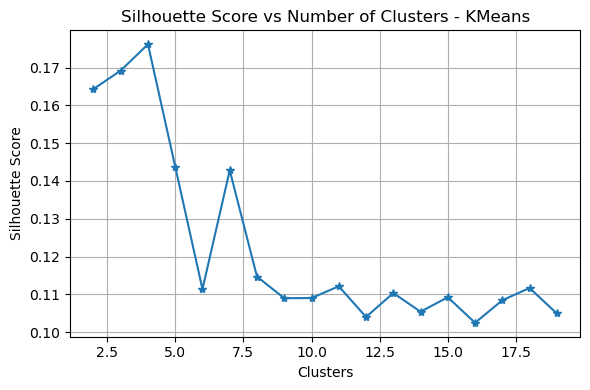

<Figure size 640x480 with 0 Axes>

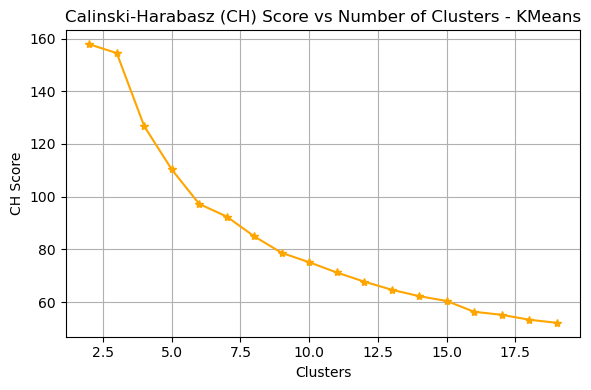

<Figure size 640x480 with 0 Axes>

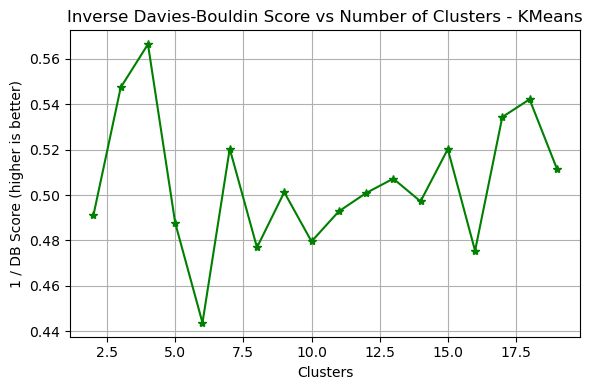

<Figure size 640x480 with 0 Axes>

In [60]:
k_means_plots = plot_the_elbows(k_pca)

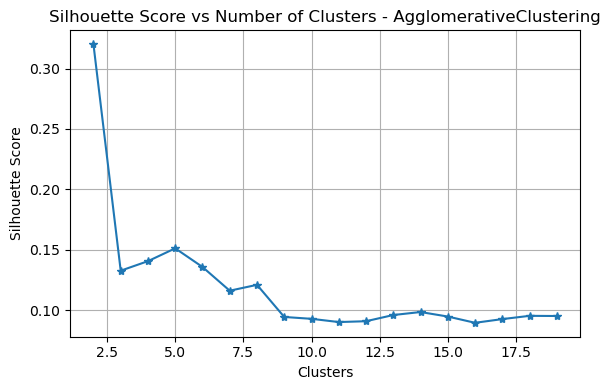

<Figure size 640x480 with 0 Axes>

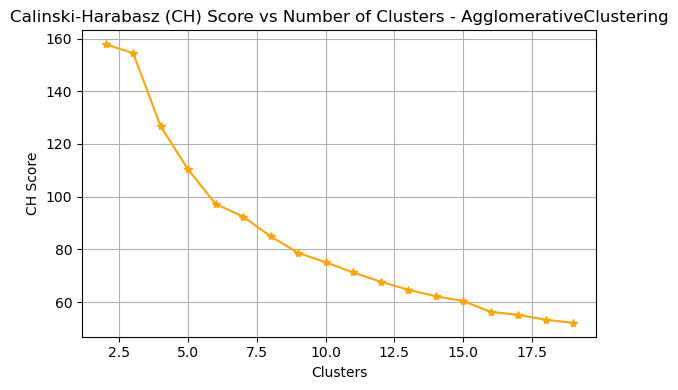

<Figure size 640x480 with 0 Axes>

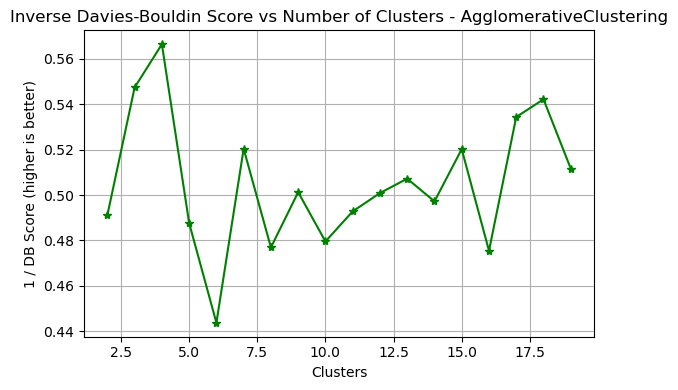

<Figure size 640x480 with 0 Axes>

In [61]:
agg_plots = plot_the_elbows(agg_pca)

In [ ]:
# After review of the models / n clusters we will test KMeans 5 & 6 clusters, as well as Agg 5 & 6 to see if we can draw any valuable conclusions.

In [ ]:
# Defining a function to automate the model process
def cluster_model_func(model, data, original_df, features,
                       n_clusters, model_name = 'Model', plot = True):
    
    model.set_params(n_clusters = n_clusters)
    labels = model.fit_predict(data)
    

,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
Number,,,,,,,,,,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,...,Green,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,...,Green,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,...,Green,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,...,Red,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,...,Red,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,Yveltal,Dark,Flying,680,126,131,95,131,98,99,...,Red,False,NaN,Undiscovered,NaN,False,5.79,203.0,45,two_wings
718,Zygarde,Dragon,Ground,600,108,100,121,81,95,95,...,Green,False,NaN,Undiscovered,NaN,False,5.00,305.0,3,serpentine_body
719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,...,Pink,False,NaN,Undiscovered,NaN,True,0.71,8.8,3,head_arms
